In [6]:
# import modules
import os
import sqlite3
from sqlite3 import Error
from skimage import color
import h5py
import time
import datetime
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def create_connection(db_file):
    '''
    create a database connection to a SQLite database
    specified by db_file
    :param db_file : database file
    :return: Connection Object or None
    '''
    conn=None
    try:
        conn=sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)  

def manggaraiDataList(maxData=True, hourOffset=0, wlstation='manggarai'):
    '''
    Returning a tuple of list (date, data) of manggarai TMA data with 10-minutes-interval from DSDA dataset in year 2020
    '''
    # read and fetch database data to pandas dataframe
    dsdaPath='../mining_dsda/dsda.db'
    conn=create_connection(dsdaPath)
    manggarai=pd.read_sql_query('SELECT * FROM {}'.format(wlstation), conn)

    # set main index to currentdate
    manggarai.set_index('currentdate')

    # convert data type from object to string
    manggaraiConv=manggarai.convert_dtypes()

    # set main index to currentdate
    manggaraiConv.set_index('currentdate')

    # convert date datatype to datetime64[ns]
    manggaraiConv['currentdate']=manggaraiConv['currentdate'].astype('datetime64[ns]')

    # slicing data to 2020 timeframe
    #mask = (manggaraiConv['currentdate'] >= '2019-02-01 00:00') & (manggaraiConv['currentdate'] <= '2021-04-03 23:50')
    mask = (manggaraiConv['currentdate'] >= '2019-02-01 00:00')
    manggaraiSlice2020=manggaraiConv.loc[mask]

    # converting 10-minute-data to hourly data
    startDate=datetime.datetime(2019,2,1)
    minutes=[x*10 for x in range(6)]
    hours=[x for x in range(24)]
    days=[x for x in range(780)]

    dateListHourly=[]
    dataListHourly=[]
    for day in days:
        for hour in hours:
            hourlyData=[]

            # set error indicator back to false
            error=False

            for minute in minutes:
                # perform data fetch, add to list, and get max value
                dateLoop=startDate+datetime.timedelta(days=day, hours=hour+hourOffset, minutes=minute)
                rowFetch=manggaraiSlice2020.loc[(manggaraiSlice2020['currentdate'] == dateLoop)]
                #print(rowFetch)

                # try to fetch if the result is not zero
                try:
                    dataFetch=rowFetch['data'].item()
                    hourlyData.append(dataFetch)
                except ValueError:
                    error=True

            # insert data if error indicator is False
            if not error:
                # make hourly date using timedelta
                hourlyDate=startDate+datetime.timedelta(days=day, hours=hour)
                
                if maxData:
                    # get maximum value of hourly data
                    maxDataHourly=max(hourlyData)
                else:
                    # get maximum value of hourly data
                    maxDataHourly=hourlyData.mean()

                # insert value to global list
                dateListHourly.append(hourlyDate)
                dataListHourly.append(maxDataHourly)
            else: # if error occured during data fetch (null or something else)
                continue # to next loop
    return dateListHourly, dataListHourly

def getHimawariFilename():
    '''
    Return dictionary of available himawari data based on filename inside
    folder as a key
    '''
    himawariPath='../mining_sadewa/sadewa/'
    # load folder name
    directory=[directory for directory in os.listdir(himawariPath)]

    # store fileame
    himawari={}

    # load all filename stored on disk to dictionary with each folder name as keys
    for direct in directory:
        fpath='{}{}'.format(himawariPath, direct)
        himawari[direct]=[fname for fname in os.listdir(fpath)]
        
    return himawari

def extractHimawariDatetime():
    '''
    Extract every filename in sadewa-himawari data to datetime object for easier handling
    
    Returns :
    extractedDate -- dictionary containing list of datetime object for each filename inside dictionary keys for every data
    '''
    himawari=getHimawariFilename()

    # extract date for each himawari data type to datetime.datetime object
    observations=['CCLD','B04','IR1','IR3','VIS']
    extractedDate={}
    for obs in observations:
        extractedDate[obs]=[datetime.datetime.strptime(x.replace('H89_{}_'.format(obs),'').replace('.png',''), '%Y%m%d%H%M') for x in himawari[obs]]

    predictions=['cloud','psf','qvapor','rain','sst','wind','winu','wn10']
    for pred in predictions:
        extractedDate[pred]=[datetime.datetime.strptime(x.replace('{}_'.format(pred),'').replace('.png','').replace('_','')+'00', '%Y%m%d%H%M') for x in himawari[pred]]
        
    return extractedDate

def getAvailableSlicedData(maxData=True, hourOffset=0, dataScope='combination', wlstation='manggarai'):
    '''
    check through all available dataset, including manggarai TMA, sadewa-himawari IR1, IR3, VIS, B04, and CCLD
    and return a tuple containing datetime object and manggarai hourly TMA data that are synced through all available dataset
    
    This function doesn't return sadewa-himawari data, because using the datetime format and the sadewa-himawari data types,
    the full name of the file required can be constructed.
    
    return : (slicedDate, slicedData) # both are lists inside a tuple
    '''
    extractedDate = extractHimawariDatetime()
        
    # getting date-data slice from himawari and manggarai TMA data

    # using function to get manggarai available date-data
    dateListHourly, dataListHourly = manggaraiDataList(maxData, hourOffset, wlstation=wlstation)

    # loop to every data
    # check algorithm : manggarai checked against every himawari data, and if all true, date is inserted to sliced data
    slicedDate=[]
    slicedData=[]
    for i in range(len(dateListHourly)):
        
        if dataScope == 'combination':
            usedData=['CCLD','B04','IR1','IR3','VIS','rain','cloud','psf','qvapor','sst']
        elif dataScope == 'prediction':
            usedData=('cloud','psf','qvapor','rain','sst','wind','winu','wn10')

        # defining control mechanism
        checked=True

        # loop through every himawari data
        for used in usedData:
            if dateListHourly[i] not in extractedDate[used]:
                checked=False # set checked to False if there are no complementary data found in another dataset

        # input data if all checked
        if checked:
            slicedDate.append(dateListHourly[i])
            slicedData.append(dataListHourly[i])
    return slicedDate, slicedData

def preparePrediction(pred, grayscale=False):
    # loop through all available data
    firstData = True
    for i in range(len(pred)):
        # loop through dataset
        firstDataset = True
        for j in range(len(pred[i])):
            if False:
                continue
            else :
                # check if grayscale or not
                if grayscale:
                    img = color.rgb2gray(color.rgba2rgb(pred[i][j]))
                    flat = img.reshape(pred[i][j].shape[0]*pred[i][j].shape[1])
                else:
                    img = pred[i][j]
                    flat = pred[i][j].reshape(pred[i][j].shape[0]*pred[i][j].shape[1]*pred[i][j].shape[2])
                
                
                if firstDataset:
                    flattened = flat.copy()
                    firstDataset = False
                else :
                    flattened = np.hstack((flattened, flat))
        if firstData:
            data = flattened.copy()
            data = data.reshape(1, data.shape[0])
            firstData = False
        else :
            flattened = flattened.reshape(1, flattened.shape[0])
            data = np.vstack((data, flattened))
    return data

def generateRNNInput(adte, adta, recurrentCount=1):
    '''
    Check and return a tuple of date containing available data for recurrent configuration
    
    This is a sub-function to restack current cropped data into rnn enabled data based on recurrentCount number
    
    Return:
    recurrentIndexList = [(index-2, index-1, index+0), (index-1, index+0, index+1), (index-recurrentCount+index, index-recurrentCount+1+index, index-recurrentCount+2+index), ...]
    availableRecurrentDate = array like containing available date in recurrent configuration (in t=0)
    availableRecurrentLabel = array like containing available data label in recurrent configuration
    '''
    
    # defining start index
    # defining list to store the recurrent index
    recurrentIndexList = []
    availableRecurrentDate = []
    availableRecurrentLabel = []
    for idx in range(len(adte[recurrentCount:])):
        # check sequence
        checkSeq = [adte[idx+recurrentCount]+datetime.timedelta(hours=-recurrentCount)+datetime.timedelta(hours=x) for x in range(recurrentCount+1)]
        realSeq = [adte[idx+x] for x in range(recurrentCount+1)]
        if checkSeq != realSeq:
            continue
        else:
            recurrentIndexList.append([idx+x for x in range(recurrentCount+1)])
            availableRecurrentDate.append(adte[idx+recurrentCount])
            availableRecurrentLabel.append(adta[idx+recurrentCount])
    
    return recurrentIndexList, availableRecurrentDate, availableRecurrentLabel

In [2]:
recurrentLists = (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71)
adte, adta = getAvailableSlicedData(maxData=True, hourOffset=0, dataScope='prediction', wlstation='manggarai')
availableRecurrentLabelsM=[]
for recurrentList in recurrentLists:
    recurrentIndexListM, availableRecurrentDateM, availableRecurrentLabelM = generateRNNInput(adte, adta, recurrentCount=recurrentList)
    availableRecurrentLabelsM.append(availableRecurrentLabelM)

In [3]:
recurrentListsK = (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36)
adteK, adtaK = getAvailableSlicedData(maxData=True, hourOffset=0, dataScope='prediction', wlstation='katulampa')
availableRecurrentLabelsK=[]
for recurrentListK in recurrentListsK:
    recurrentIndexListK, availableRecurrentDateK, availableRecurrentLabelK = generateRNNInput(adteK, adtaK, recurrentCount=recurrentListK)
    availableRecurrentLabelsK.append(availableRecurrentLabelK)

In [23]:
# store label to hdf5 format
WLSTATIONS = ('manggarai', 'katulampa')
RECURRENTS = ((1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71), (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36))
LABELS = (availableRecurrentLabelsM, availableRecurrentLabelsK)
for i in range(len(WLSTATIONS)):
    for j in range(len(RECURRENTS[i])):
        with h5py.File(f'./labels/{WLSTATIONS[i]}r{RECURRENTS[i][j]}.hdf5', 'w') as f:
            norm, _, _ = normalizingLabels(np.array(LABELS[i][j]).astype('float32'))
            f.create_dataset('datas', data=norm)

In [4]:
manggaraiData = [len(x) for x in availableRecurrentLabelsM]
katulampaData = [len(x) for x in availableRecurrentLabelsK]

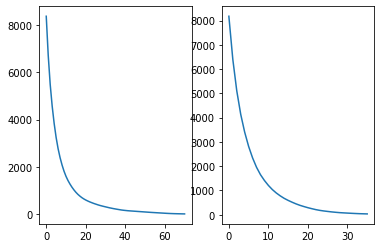

In [30]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.plot(manggaraiData)
plt.subplot(1,2,2)
plt.plot(katulampaData)
plt.show()

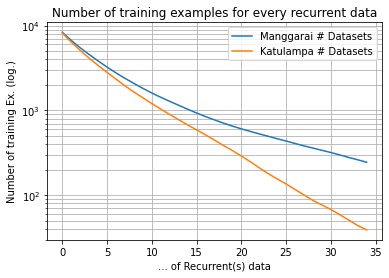

In [7]:
plt.plot(manggaraiData[:35], label='Manggarai # Datasets')
plt.plot(katulampaData[:35], label='Katulampa # Datasets')
plt.yscale('log')
plt.title('Number of training examples for every recurrent data')
plt.xlabel('... of Recurrent(s) data')
plt.ylabel('Number of training Ex. (log.)')
plt.grid(which='both')
plt.legend()
plt.show()

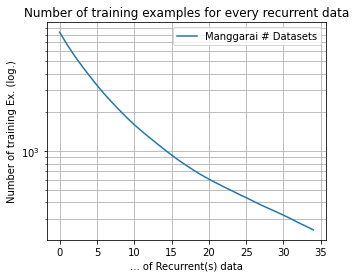

In [12]:
plt.figure(figsize=(5,4))
plt.plot(manggaraiData[:35], label='Manggarai # Datasets')
plt.yscale('log')
plt.title('Number of training examples for every recurrent data')
plt.xlabel('... of Recurrent(s) data')
plt.ylabel('Number of training Ex. (log.)')
plt.grid(which='both')
plt.legend()
plt.show()

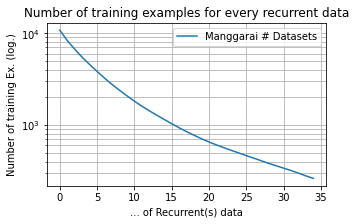

In [26]:
# no recurrent data : 10815 data
revManggaraiData = [10815]
for md in manggaraiData:
    revManggaraiData.append(md)
plt.figure(figsize=(5,3))
plt.plot(revManggaraiData[:35], label='Manggarai # Datasets')
plt.yscale('log')
plt.title('Number of training examples for every recurrent data')
plt.xlabel('... of Recurrent(s) data')
plt.ylabel('Number of training Ex. (log.)')
plt.grid(which='both')
plt.legend()
plt.show()